## SUMMARY

* Weekly average cases from each state was computed and weekly avarge in a year ago was used as a feature.
* Model performance was improved to 0.74 (r^2 score)
* A two-layer LSTM model were used, performance was poor (Model maybe underfit and need to change the architecture or increase the epochs)

## Answer

* Please report the forecasted values for the 20-day period for each of the states.

(Please see the attachment prediction.csv)

* Please visualize the evolving ILI intensity throughout the Winter season of 2017/8, including your
forecasted values.

(see 1-EDA.ipynb Figure 2)

* Please characterize the performance of the model and suggest potential improvements.

    * GBM with general time related feature: R_square = 0.73, MSE = 2.3E8
    * GBM with general time features and weekly avaerage feature from previous year: R_square = 0.74, MSE = 2.2E8


* Why did you select a particular model?

    * Use GBM because 1) it is fast to train (takes 2 mins in this case) 2) usually have robust performance 3) Grid search was performed by AutoML
    

* What other approaches may work?

    * Conventional time series model such as ARIMA
    * For LSTM, we may try to use a different architechture and different activation functions. To avoid underfitting we may need to train for longer epochs.
    
* How would your approach change if you had more granular data (counties, zip codes)?

    * For the current GBM model, these features may not change the model performance because it is on the state level
    * Instead, if we were to build a geospatial model these features may be helpful to model the disease transmission on a temporal spatial level (we can look at spatial autocorrelation, temporal spatio clustering to determine the outbreak center and the scale of disease transmission). 


* How would your approach change if you needed to make predictions three months ahead rather
than three weeks ahead?

    * If we were to predict three months ahead we might need a longer time frame for the training data. We also need to estimate the R_0 and beta (effective contact rate), incorporate those into the model to better predict the progression of flu transmission. 


* Which other data sources would you include if you had more time for this problem?

    * Population mobility between PA, NY and NJ; this helps to predict the total number of ILI cases in each states
    * The estimation of R_0 and beta for the subtype of influenza virus that is currently circulating
    * Vaccine efficacy, population immunity, recovering time, etc

## Load data

In [704]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from datetime import datetime
from scipy import stats
import scipy.stats as ss
from h2o.automl import H2OAutoML
from keras.models import Sequential

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.utils import to_categorical
import operator
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [705]:
import sys
sys.executable
import h2o

from sklearn.metrics import r2_score, mean_squared_error

In [706]:
from datetime import datetime
import time

In [707]:
mydata = pd.read_csv('state_traces.csv', index_col=[0])
mydata.head()

,state,date,value
107,NJ,20151002,4293.414810
108,NJ,20151003,5977.121664
109,NJ,20151004,1903.517673
110,NJ,20151005,20754.601160
111,NJ,20151006,12885.652476


In [708]:
mydata['month'] = [str(i)[4:6] for i in mydata.date]
mydata['datestr'] = [(str(i)[:4]+'-' + str(i)[4:6] + '-' + str(i)[6:]) for i in mydata.date]
mydata['dateobj'] = [datetime.strptime(i, "%Y-%m-%d") for i in mydata.datestr]
mydata['timestamp'] = [time.mktime(i.timetuple()) for i in mydata.dateobj]
mydata['year'] = [str(i)[:4] for i in mydata.datestr]


In [709]:
mydata.head()

,state,date,value,month,datestr,dateobj,timestamp,year
107,NJ,20151002,4293.414810,10,2015-10-02,2015-10-02,1.443766e+09,2015
108,NJ,20151003,5977.121664,10,2015-10-03,2015-10-03,1.443852e+09,2015
109,NJ,20151004,1903.517673,10,2015-10-04,2015-10-04,1.443938e+09,2015
110,NJ,20151005,20754.601160,10,2015-10-05,2015-10-05,1.444025e+09,2015
111,NJ,20151006,12885.652476,10,2015-10-06,2015-10-06,1.444111e+09,2015


In [710]:
mydata['DOY'] = [time.strftime('%j', time.gmtime(i)) for i in mydata.timestamp]
mydata['DOM'] = [time.strftime('%d', time.gmtime(i)) for i in mydata.timestamp]
mydata['DOW'] = [time.strftime('%w', time.gmtime(i)) for i in mydata.timestamp]
mydata['Week'] = [time.strftime('%U', time.gmtime(i)) for i in mydata.timestamp]

In [711]:
mydata.head()

,state,date,value,month,datestr,dateobj,timestamp,year,DOY,DOM,DOW,Week
107,NJ,20151002,4293.414810,10,2015-10-02,2015-10-02,1.443766e+09,2015,275,02,5,39
108,NJ,20151003,5977.121664,10,2015-10-03,2015-10-03,1.443852e+09,2015,276,03,6,39
109,NJ,20151004,1903.517673,10,2015-10-04,2015-10-04,1.443938e+09,2015,277,04,0,40
110,NJ,20151005,20754.601160,10,2015-10-05,2015-10-05,1.444025e+09,2015,278,05,1,40
111,NJ,20151006,12885.652476,10,2015-10-06,2015-10-06,1.444111e+09,2015,279,06,2,40


In [712]:
cm = plt.get_cmap('viridis')

In [713]:
plt.rc('axes', prop_cycle=(cycler('color', [cm(1/float(i)) for i in range(1,5)]) ))

### Add weekly average feature (not moving average)

In [714]:
weekly = mydata[['state','year','Week', 'value']]\
.groupby(['state','year', 'Week'])['value'].mean().reset_index()
weekly.head()

,state,year,Week,value
0,NJ,2015,39,5135.268237
1,NJ,2015,40,12150.925737
2,NJ,2015,41,13496.370331
3,NJ,2015,42,11221.587924
4,NJ,2015,43,11810.641927


In [715]:
weekly.rename(columns = {'value':'weekly_avg'}, inplace = True)

In [716]:
mydata = mydata.merge(weekly, how='left', on=['state', 'year', 'Week'])

In [717]:
mydata.head()

,state,date,value,month,datestr,dateobj,timestamp,year,DOY,DOM,DOW,Week,weekly_avg
0,NJ,20151002,4293.414810,10,2015-10-02,2015-10-02,1.443766e+09,2015,275,02,5,39,5135.268237
1,NJ,20151003,5977.121664,10,2015-10-03,2015-10-03,1.443852e+09,2015,276,03,6,39,5135.268237
2,NJ,20151004,1903.517673,10,2015-10-04,2015-10-04,1.443938e+09,2015,277,04,0,40,12150.925737
3,NJ,20151005,20754.601160,10,2015-10-05,2015-10-05,1.444025e+09,2015,278,05,1,40,12150.925737
4,NJ,20151006,12885.652476,10,2015-10-06,2015-10-06,1.444111e+09,2015,279,06,2,40,12150.925737


In [718]:
time_list = dict()

for state in mydata.state.unique():
    mymin = mydata[mydata.state == state]['timestamp'].min()
    mymax = mydata[mydata.state == state]['timestamp'].max()
    mysp1 = mymin + (mymax-mymin)*.8
    mysp2 = mymin + (mymax - mymin)*.9
    print(state, " : ", mymin, mymax)
    time_list.update({state: [mysp1, mysp2, mymax]})

time_list

NJ  :  1443765600.0 1516777200.0
NY  :  1443765600.0 1516777200.0
PA  :  1443765600.0 1516777200.0


{'NJ': [1502174880.0, 1509476040.0, 1516777200.0],
 'NY': [1502174880.0, 1509476040.0, 1516777200.0],
 'PA': [1502174880.0, 1509476040.0, 1516777200.0]}

In [719]:
mytrain = pd.DataFrame()
mycv = pd.DataFrame()
mytest = pd.DataFrame()

for state in mydata.state.unique():
    train = mydata[(mydata.state == state)& (mydata.timestamp < time_list[state][0] )]
    mytrain = mytrain.append(pd.DataFrame(data = train), ignore_index = True)
    
    cv = mydata[(mydata.state == state) & (mydata.timestamp >= time_list[state][0]) & (mydata.timestamp < time_list[state][1])]
    mycv = mycv.append(pd.DataFrame(data = cv), ignore_index = True)
    
    test = mydata[(mydata.state == state) & (mydata.timestamp >= time_list[state][1])]
    mytest = mytest.append(pd.DataFrame(data = test), ignore_index = True)
 

In [730]:
mytest.head()

,state,date,value,month,datestr,dateobj,timestamp,year,DOY,DOM,DOW,Week,weekly_avg
0,NJ,20171101,46918.389135,11,2017-11-01,2017-11-01,1.509516e+09,2017,305,01,3,44,34047.512693
1,NJ,20171102,33927.370164,11,2017-11-02,2017-11-02,1.509602e+09,2017,306,02,4,44,34047.512693
2,NJ,20171103,41595.745103,11,2017-11-03,2017-11-03,1.509689e+09,2017,307,03,5,44,34047.512693
3,NJ,20171104,30669.005574,11,2017-11-04,2017-11-04,1.509775e+09,2017,308,04,6,44,34047.512693
4,NJ,20171105,42062.320246,11,2017-11-05,2017-11-05,1.509862e+09,2017,309,05,0,45,30873.651164


### Use weekly_avg of previous year as weekly_avg 

In [748]:
for i in range(0, 255):
    week_num = mytest.Week[i]
    my_state = mytest.state[i]
    my_year = mytest.year[i]
    if int(week_num) <= 52 and int(my_year) == 2017:
        mytest.weekly_avg[i] = mydata[(mydata.year == '2016') & (mydata.Week == week_num) & (mydata.state == my_state)]['weekly_avg'].values[0]
    elif int(week_num) <= 52 and int(week_num) > 0 and int(my_year) == 2018:
        print('2018 use 2017 same week: ', week_num, my_state)
        mytest.weekly_avg[i] = mydata[(mydata.year == '2017') & (mydata.Week == week_num) & (mydata.state == my_state)]['weekly_avg'].values[0]
    elif int(week_num) <= 52 and int(week_num) == 0 and int(my_year) == 2018:
        print('2018 use week1: ', week_num, my_state)
        mytest.weekly_avg[i] = mydata[(mydata.year == '2017') & (mydata.Week == '01') & (mydata.state == my_state)]['weekly_avg'].values[0]
    else:
        print('use 2016 week 52: ',week_num, my_state, my_year)
        mytest.weekly_avg[i] = mydata[(mydata.year == '2016') & (mydata.Week == '52') & (mydata.state == my_state)]['weekly_avg'].values[0]

use 2016 week 52:  53 NJ 2017
2018 use week1:  00 NJ
2018 use week1:  00 NJ
2018 use week1:  00 NJ
2018 use week1:  00 NJ
2018 use week1:  00 NJ
2018 use week1:  00 NJ
2018 use 2017 same week:  01 NJ
2018 use 2017 same week:  01 NJ
2018 use 2017 same week:  01 NJ
2018 use 2017 same week:  01 NJ
2018 use 2017 same week:  01 NJ
2018 use 2017 same week:  01 NJ
2018 use 2017 same week:  01 NJ
2018 use 2017 same week:  02 NJ
2018 use 2017 same week:  02 NJ
2018 use 2017 same week:  02 NJ
2018 use 2017 same week:  02 NJ
2018 use 2017 same week:  02 NJ
2018 use 2017 same week:  02 NJ
2018 use 2017 same week:  02 NJ
2018 use 2017 same week:  03 NJ
2018 use 2017 same week:  03 NJ
2018 use 2017 same week:  03 NJ
2018 use 2017 same week:  03 NJ
use 2016 week 52:  53 NY 2017
2018 use week1:  00 NY
2018 use week1:  00 NY
2018 use week1:  00 NY
2018 use week1:  00 NY
2018 use week1:  00 NY
2018 use week1:  00 NY
2018 use 2017 same week:  01 NY
2018 use 2017 same week:  01 NY
2018 use 2017 same week:

In [741]:
   
h2o.init() 
    
mytrainhdf = h2o.H2OFrame(mytrain)
mycvhdf = h2o.H2OFrame(mycv)
mytesthdf = h2o.H2OFrame(mytest)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 day 11 hours 40 mins
H2O cluster timezone:,America/Denver
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.5
H2O cluster version age:,3 days
H2O cluster name:,H2O_from_python_xiguo_bjroes
H2O cluster total nodes:,1
H2O cluster free memory:,590 Mb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [742]:
x = mytrainhdf.columns
y = "value"
x.remove(y)

aml = H2OAutoML(max_runtime_secs = 30)
aml.train(x = x, y = y,
          training_frame = mytrainhdf, validation_frame = mycvhdf, leaderboard_frame = mycvhdf)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid_0_AutoML_20180812_202822_model_4,8.4912e+07,9214.77,8.4912e+07,7168.01,0.240027
GBM_grid_0_AutoML_20180812_202822_model_1,8.72064e+07,9338.44,8.72064e+07,7240.1,0.239435
GBM_grid_0_AutoML_20180812_202822_model_2,9.14371e+07,9562.28,9.14371e+07,7410.27,0.248181
GBM_grid_0_AutoML_20180812_202822_model_0,9.30689e+07,9647.22,9.30689e+07,7368.01,0.242193
GBM_grid_0_AutoML_20180812_202822_model_3,9.61558e+07,9805.91,9.61558e+07,7484.08,0.245399
DRF_0_AutoML_20180812_202822,1.00637e+08,10031.8,1.00637e+08,7712.17,0.256934
XRT_0_AutoML_20180812_202822,1.06261e+08,10308.3,1.06261e+08,8026.2,0.259931
GBM_grid_0_AutoML_20180812_202822_model_6,1.06475e+08,10318.7,1.06475e+08,7974.48,0.261226
GBM_grid_0_AutoML_20180812_202822_model_5,1.32989e+08,11532.1,1.32989e+08,8977.47,0.290967
DeepLearning_0_AutoML_20180812_202822,1.465e+08,12103.7,1.465e+08,9228.87,0.298824


In [743]:
mypred = aml.leader.predict(mytesthdf)
mypredpd = mypred.as_data_frame()
mypredpd = mypredpd.reset_index()
mymerge = pd.concat([mytest, mypredpd], axis = 1)

gbm prediction progress: |████████████████████████████████████████████████| 100%


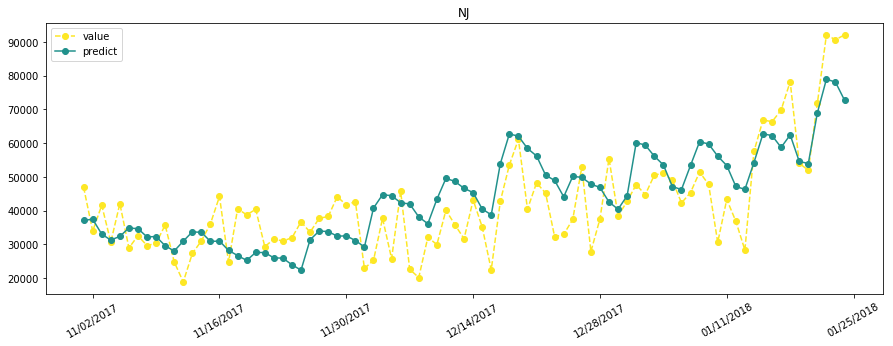

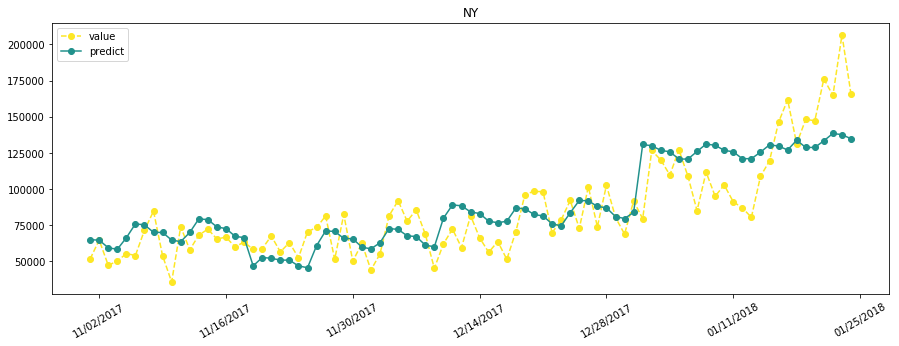

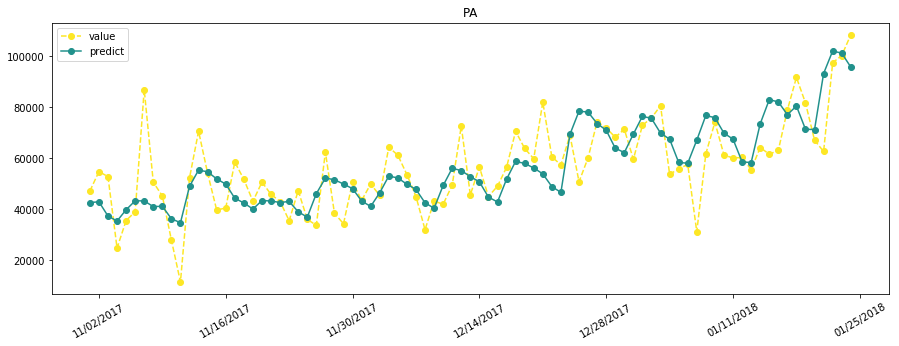

In [744]:
plt.rcParams['figure.figsize'] = (15, 5)
formatter = DateFormatter('%m/%d/%Y')

for state in mymerge.state.unique():
    mysub = mymerge[mymerge.state == state]
    mysub['datestr'] = [str(i) for i in mysub.date]
    mysub['num'] = mdates.datestr2num(mysub.datestr)
    fig, ax = plt.subplots()
    plt.plot_date(mysub.num, mysub.value, ls = '--')
    plt.plot_date(mysub.num, mysub.predict, ls = '-')
    #ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_tick_params(rotation=30, labelsize=10)
    plt.legend()
    plt.title(state)

In [749]:
r2_score(mymerge.value, mymerge.predict), mean_squared_error(mymerge.value, mymerge.predict)

(0.7468537028710547, 218170712.67592457)

In [832]:
aml.leader.model_performance()


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 101956057.63884553
RMSE: 10097.32923296282
MAE: 7366.651233336892
RMSLE: 0.242712810531222
Mean Residual Deviance: 101956057.63884553


### Generate prediction

In [750]:
### Dummy dataset
pd.options.mode.chained_assignment = None 

In [751]:
mynew_set = mytest[mytest.timestamp > 1515049200.0]
mynew_time = mytest[mytest.timestamp > 1515049200.0]['timestamp'] + 60*60*24*20
mynew_time = mynew_time.values

In [752]:
mynew_set.state.value_counts()

PA    20
NJ    20
NY    20
Name: state, dtype: int64

In [753]:
mynew_set['timestamp'] = mynew_time

In [754]:
mynew_set.head()

,state,date,value,month,datestr,dateobj,timestamp,year,DOY,DOM,DOW,Week,weekly_avg
65,NJ,20180105,48980.110242,01,2018-01-05,2018-01-05,1.516864e+09,2018,005,05,5,00,54600.508337
66,NJ,20180106,42271.709522,01,2018-01-06,2018-01-06,1.516950e+09,2018,006,06,6,00,54600.508337
67,NJ,20180107,45361.771549,01,2018-01-07,2018-01-07,1.517036e+09,2018,007,07,0,01,54600.508337
68,NJ,20180108,51420.319156,01,2018-01-08,2018-01-08,1.517123e+09,2018,008,08,1,01,54600.508337
69,NJ,20180109,47762.834157,01,2018-01-09,2018-01-09,1.517209e+09,2018,009,09,2,01,54600.508337


In [755]:
mynew_set['date'] = [datetime.utcfromtimestamp(i).strftime('%Y%m%d') for i in mynew_time]

In [756]:
mynew_set['month'] = [str(i)[4:6] for i in mynew_set.date]
mynew_set['datestr'] = [(str(i)[:4]+'-' + str(i)[4:6] + '-' + str(i)[6:]) for i in mynew_set.date]
mynew_set['dateobj'] = [datetime.strptime(i, "%Y-%m-%d") for i in mynew_set.datestr]
mynew_set['DOY'] = [time.strftime('%j', time.gmtime(i)) for i in mynew_set.timestamp]
mynew_set['DOM'] = [time.strftime('%d', time.gmtime(i)) for i in mynew_set.timestamp]
mynew_set['DOW'] = [time.strftime('%w', time.gmtime(i)) for i in mynew_set.timestamp]
mynew_set['Week'] = [time.strftime('%U', time.gmtime(i)) for i in mynew_set.timestamp]
mynew_set['year'] = [str(i)[:4] for i in mynew_set.datestr]
#mynew_set['timestamp'] = [time.mktime(i.timetuple()) for i in mynew_set.dateobj]

In [757]:
mynew_set.head()

,state,date,value,month,datestr,dateobj,timestamp,year,DOY,DOM,DOW,Week,weekly_avg
65,NJ,20180125,48980.110242,01,2018-01-25,2018-01-25,1.516864e+09,2018,025,25,4,03,54600.508337
66,NJ,20180126,42271.709522,01,2018-01-26,2018-01-26,1.516950e+09,2018,026,26,5,03,54600.508337
67,NJ,20180127,45361.771549,01,2018-01-27,2018-01-27,1.517036e+09,2018,027,27,6,03,54600.508337
68,NJ,20180128,51420.319156,01,2018-01-28,2018-01-28,1.517123e+09,2018,028,28,0,04,54600.508337
69,NJ,20180129,47762.834157,01,2018-01-29,2018-01-29,1.517209e+09,2018,029,29,1,04,54600.508337


In [802]:
mynew_set.year.value_counts()

2018    60
Name: year, dtype: int64

In [801]:
mynew_set.month.value_counts()

02    39
01    21
Name: month, dtype: int64

In [796]:
mynew_set.shape

(60, 13)

### Use weekly_avg of previous year as weekly_avg and monthly_avg

In [806]:
myjoin = mydata[(mydata.year == '2017') & (mydata.month.isin(['02', '01']))][['Week', 'month', 'weekly_avg', 'state']]

In [807]:
myjoin = myjoin.drop_duplicates()
myjoin.shape

(30, 4)

In [808]:
mynew_join = mynew_set.merge(myjoin, on = [ 'Week', 'month', 'state'], how = 'left')

In [809]:
mynew_join.head()

,state,date,value,month,datestr,dateobj,timestamp,year,DOY,DOM,DOW,Week,weekly_avg_x,weekly_avg_y
0,NJ,20180125,48980.110242,01,2018-01-25,2018-01-25,1.516864e+09,2018,025,25,4,03,54600.508337,67048.995579
1,NJ,20180126,42271.709522,01,2018-01-26,2018-01-26,1.516950e+09,2018,026,26,5,03,54600.508337,67048.995579
2,NJ,20180127,45361.771549,01,2018-01-27,2018-01-27,1.517036e+09,2018,027,27,6,03,54600.508337,67048.995579
3,NJ,20180128,51420.319156,01,2018-01-28,2018-01-28,1.517123e+09,2018,028,28,0,04,54600.508337,73941.504183
4,NJ,20180129,47762.834157,01,2018-01-29,2018-01-29,1.517209e+09,2018,029,29,1,04,54600.508337,73941.504183


In [810]:
mynew_join.shape, myjoin.shape

((60, 14), (30, 4))

In [812]:
mynew_join.tail()

,state,date,value,month,datestr,dateobj,timestamp,year,DOY,DOM,DOW,Week,weekly_avg_x,weekly_avg_y
55,PA,20180209,67120.212707,02,2018-02-09,2018-02-09,1.518160e+09,2018,040,09,5,05,78306.903069,93393.197191
56,PA,20180210,62688.337368,02,2018-02-10,2018-02-10,1.518246e+09,2018,041,10,6,05,92211.422877,93393.197191
57,PA,20180211,97523.298547,02,2018-02-11,2018-02-11,1.518332e+09,2018,042,11,0,06,92211.422877,114871.061174
58,PA,20180212,100371.022721,02,2018-02-12,2018-02-12,1.518419e+09,2018,043,12,1,06,92211.422877,114871.061174
59,PA,20180213,108471.555057,02,2018-02-13,2018-02-13,1.518505e+09,2018,044,13,2,06,92211.422877,114871.061174


In [813]:
mynew_join['weekly_avg'] = (mynew_join['weekly_avg_x'] +  mynew_join['weekly_avg_y'])/float(2)


In [814]:
mynew_join.head()

,state,date,value,month,datestr,dateobj,timestamp,year,DOY,DOM,DOW,Week,weekly_avg_x,weekly_avg_y,weekly_avg
0,NJ,20180125,48980.110242,01,2018-01-25,2018-01-25,1.516864e+09,2018,025,25,4,03,54600.508337,67048.995579,60824.751958
1,NJ,20180126,42271.709522,01,2018-01-26,2018-01-26,1.516950e+09,2018,026,26,5,03,54600.508337,67048.995579,60824.751958
2,NJ,20180127,45361.771549,01,2018-01-27,2018-01-27,1.517036e+09,2018,027,27,6,03,54600.508337,67048.995579,60824.751958
3,NJ,20180128,51420.319156,01,2018-01-28,2018-01-28,1.517123e+09,2018,028,28,0,04,54600.508337,73941.504183,64271.006260
4,NJ,20180129,47762.834157,01,2018-01-29,2018-01-29,1.517209e+09,2018,029,29,1,04,54600.508337,73941.504183,64271.006260


In [815]:
mynew_join.shape

(60, 15)

In [816]:
mytrainhdf.shape

(2031, 13)

In [817]:
mynew_test = mynew_join.iloc[:, :12] 
mynew_test.state.value_counts()

PA    20
NJ    20
NY    20
Name: state, dtype: int64

In [818]:
mynew_test['weekly_avg'] = mynew_join['weekly_avg']


In [819]:
mynew_test.head()

,state,date,value,month,datestr,dateobj,timestamp,year,DOY,DOM,DOW,Week,weekly_avg
0,NJ,20180125,48980.110242,01,2018-01-25,2018-01-25,1.516864e+09,2018,025,25,4,03,60824.751958
1,NJ,20180126,42271.709522,01,2018-01-26,2018-01-26,1.516950e+09,2018,026,26,5,03,60824.751958
2,NJ,20180127,45361.771549,01,2018-01-27,2018-01-27,1.517036e+09,2018,027,27,6,03,60824.751958
3,NJ,20180128,51420.319156,01,2018-01-28,2018-01-28,1.517123e+09,2018,028,28,0,04,64271.006260
4,NJ,20180129,47762.834157,01,2018-01-29,2018-01-29,1.517209e+09,2018,029,29,1,04,64271.006260


In [820]:
mynew_test = mynew_test.drop_duplicates()

In [821]:
mynew_test.DOW.value_counts()

1    9
6    9
4    9
2    9
5    9
0    9
3    6
Name: DOW, dtype: int64

In [822]:
mynew_test.shape

(60, 13)

In [823]:
mynew_testhdf = h2o.H2OFrame(mynew_test)

/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [824]:
mypred = aml.leader.predict(mynew_testhdf)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [826]:
mypredpd = mypred.as_data_frame()
mypredpd = mypredpd.reset_index()
mymerge = pd.concat([mynew_test, mypredpd], axis = 1)

In [827]:
mymerge.state.value_counts()

PA    20
NJ    20
NY    20
Name: state, dtype: int64

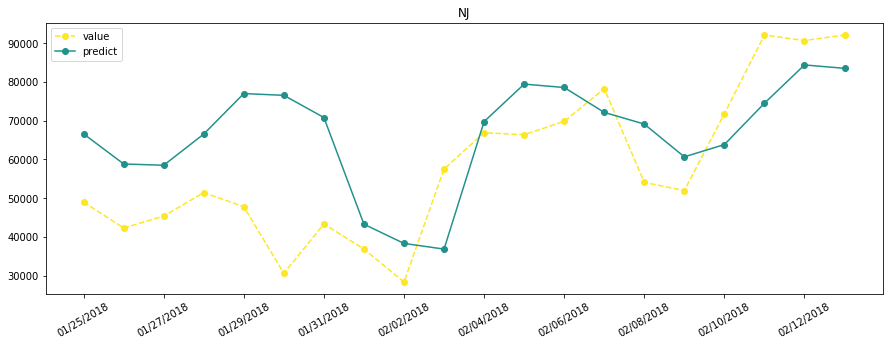

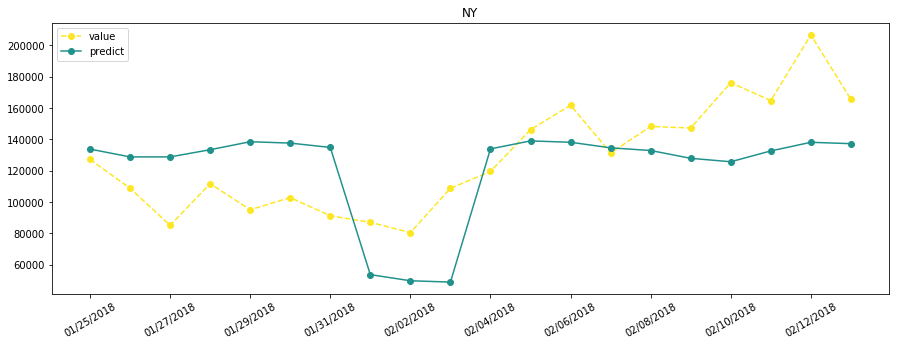

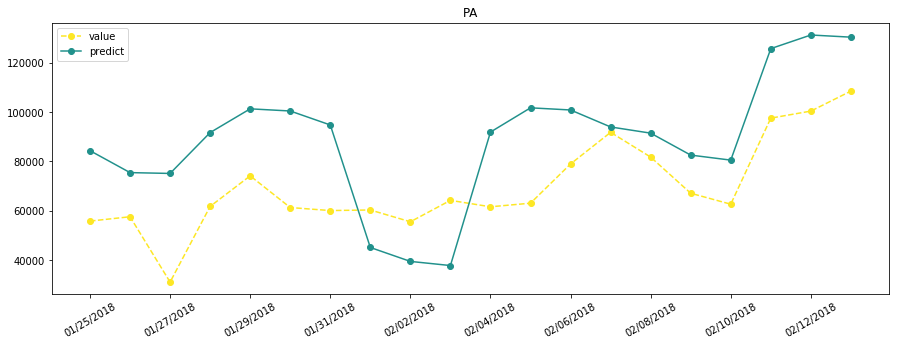

In [828]:
plt.rcParams['figure.figsize'] = (15, 5)
formatter = DateFormatter('%m/%d/%Y')

for state in mymerge.state.unique():
    mysub = mymerge[mymerge.state == state]
    mysub['datestr'] = [str(i) for i in mysub.date]
    mysub['num'] = mdates.datestr2num(mysub.datestr)
    fig, ax = plt.subplots()
    plt.plot_date(mysub.num, mysub.value, ls = '--')
    plt.plot_date(mysub.num, mysub.predict, ls = '-')
    #ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_tick_params(rotation=30, labelsize=10)
    plt.legend()
    plt.title(state)



In [834]:
mymerge.head()

,state,date,value,month,datestr,dateobj,timestamp,year,DOY,DOM,DOW,Week,weekly_avg,index,predict
0,NJ,20180125,48980.110242,01,2018-01-25,2018-01-25,1.516864e+09,2018,025,25,4,03,60824.751958,0,66574.398378
1,NJ,20180126,42271.709522,01,2018-01-26,2018-01-26,1.516950e+09,2018,026,26,5,03,60824.751958,1,58810.693249
2,NJ,20180127,45361.771549,01,2018-01-27,2018-01-27,1.517036e+09,2018,027,27,6,03,60824.751958,2,58474.479245
3,NJ,20180128,51420.319156,01,2018-01-28,2018-01-28,1.517123e+09,2018,028,28,0,04,64271.006260,3,66533.061637
4,NJ,20180129,47762.834157,01,2018-01-29,2018-01-29,1.517209e+09,2018,029,29,1,04,64271.006260,4,76979.733235


In [835]:
mymerge.to_csv('prediction.csv', index = False)

## LSTM

### Data preparation

In [448]:
for i in mydata.columns:
    print(i)
    print(type(mydata[i][0]))

state
<class 'str'>
date
<class 'numpy.int64'>
value
<class 'numpy.float64'>
month
<class 'str'>
datestr
<class 'str'>
dateobj
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
timestamp
<class 'numpy.float64'>
year
<class 'str'>
DOY
<class 'str'>
DOM
<class 'str'>
DOW
<class 'str'>
Week
<class 'str'>
weekly_avg
<class 'numpy.float64'>
monthly_avg
<class 'numpy.float64'>


In [449]:
scaled.shape

(2538, 963)

In [456]:
y = mydata['value']

In [457]:
mytrain = pd.DataFrame()
mycv = pd.DataFrame()
mytest = pd.DataFrame()


for state in mydata.state.unique():
    train = mydata[(mydata.state == state)& (mydata.timestamp < time_list[state][0] )]
    mytrain = mytrain.append(pd.DataFrame(data = train), ignore_index = True)
    
    cv = mydata[(mydata.state == state) & (mydata.timestamp >= time_list[state][0]) & (mydata.timestamp < time_list[state][1])]
    mycv = mycv.append(pd.DataFrame(data = cv), ignore_index = True)
    
    test = mydata[(mydata.state == state) & (mydata.timestamp >= time_list[state][1])]
    mytest = mytest.append(pd.DataFrame(data = test), ignore_index = True)
    


In [458]:
mynewdata = mytrain.append(mycv)
mynewdata = mynewdata.append(mytest)

In [459]:
mynewdata.shape, mytrain.shape, mycv.shape, mytest.shape

((2538, 14), (2031, 14), (252, 14), (255, 14))

In [460]:
mynewdata['timestamp'] = mynewdata['timestamp'].astype('int')
mynewdata['dateobj'] = mynewdata['dateobj'].astype('int')
mynewdata['DOY'] = mynewdata['DOY'].astype('int')
mydummy = pd.get_dummies(mynewdata.drop(['value', 'datestr'], axis = 1))
values = mydummy.values
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

y = mynewdata['value']

In [461]:
scaled.shape, y.shape, mytrain.shape, mycv.shape, mytest.shape

((2538, 117), (2538,), (2031, 14), (252, 14), (255, 14))

In [421]:
n_num = 2283

train_X, train_y = scaled[:n_num, :], y[:n_num]
test_X, test_y = scaled[n_num:, :], y[n_num:]
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)



(2283, 963) (2283,)
(255, 963) (255,)
(2283, 1, 963) (2283,)
(255, 1, 963) (255,)


In [464]:
from keras.layers.core import Dense, Activation, Dropout


In [466]:
def build_model():
    print('Building model...')
    model = Sequential()
    model.add(LSTM(117, input_shape = (train_X.shape[1], train_X.shape[2]),
                   return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(117, return_sequences=False))
    model.add(Dense(1, activation = 'relu'))

    model.compile(loss='mae',metrics=['mae'], optimizer= "RMSprop")
    return model

def train(model):
    print('Train...')
    history = model.fit(train_X, train_y,
              batch_size=7,
              epochs=30, validation_data=(test_X, test_y), shuffle = False)
    score = model.evaluate(test_X, test_y, batch_size=7)
    
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    print('Test score:', score)



Building model...
Train...
Train on 2283 samples, validate on 255 samples
Epoch 1/30
2283/2283 [==============================] - 10s 4ms/step - loss: 47285.4441 - mean_absolute_error: 47285.4441 - val_loss: 61004.1652 - val_mean_absolute_error: 61004.1652
Epoch 2/30
2283/2283 [==============================] - 2s 899us/step - loss: 47253.6616 - mean_absolute_error: 47253.6616 - val_loss: 60974.6987 - val_mean_absolute_error: 60974.6987
Epoch 3/30
2283/2283 [==============================] - 2s 868us/step - loss: 47224.1969 - mean_absolute_error: 47224.1969 - val_loss: 60945.2339 - val_mean_absolute_error: 60945.2339
Epoch 4/30
2283/2283 [==============================] - 2s 883us/step - loss: 47194.7310 - mean_absolute_error: 47194.7310 - val_loss: 60915.7686 - val_mean_absolute_error: 60915.7686
Epoch 5/30
2283/2283 [==============================] - 2s 946us/step - loss: 47165.2649 - mean_absolute_error: 47165.2649 - val_loss: 60886.3000 - val_mean_absolute_error: 60886.3000
Epoch 6

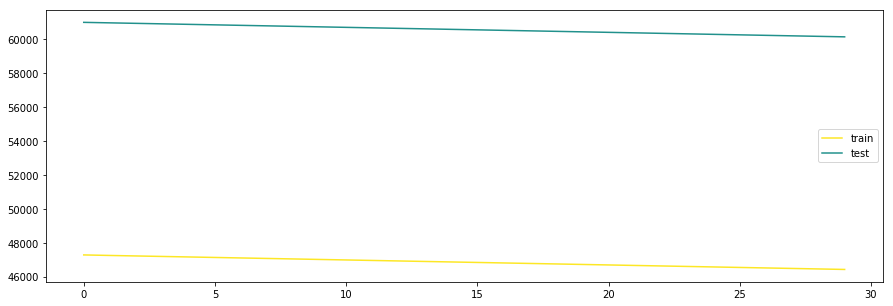

Test score: [60149.648054534315, 60149.648054534315]


In [467]:
my_lstm = build_model()
train(my_lstm)

In [186]:
### TODO

### FEATURE ENG for row diff

## model row diff

## MObility

## ADD FLU SEASON

## LSTM